# **Setup**

1. Dependencies Installieren

In [ ]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

2. Package importieren

In [1]:
#Packung für das Sammeln durch den Webcam
import os, time, uuid, cv2
from pathlib import Path

In [2]:
#Packung für Bilderverarbeitung
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Packung für die Ablumentation und die Bildung der Data-Pipeline
import albumentations as alb

In [4]:
#Packung für das Modelbau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [5]:
#Model Speicherung
from tensorflow.keras.models import load_model

# Limit GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Getting the right PATH

In [8]:
current_path = Path().resolve()
print(current_path)

C:\Users\ttt\Documents\GitHub\BilderkennungAI


In [9]:
%pwd

'c:\\Users\\ttt\\Documents\\GitHub\\BilderkennungAI'

# Bilder labeln



```
!labelme
```

Labelme öffnen, um Ausgangsdaten mit Labels zu versehen, dort wo Gesichter zu sehen sind (nach Akzepentanzkritierien PROJ-71)

Rechteck um das Gesicht, wenn kein Gesicht vorhanden Datei ignorieren

Labels als json in den labels Ordner übertragen

# **3. Die gesamte Datenmenge in kleineren Gruppen aufteilen**

Trennung der data/images Ordner in 3 kleineren Ordnern
```
#training_set
for x in range(int(len(l)*0.7)+1):
  file = l[x]
  EX_PATH = os.path.join("data","images",file)
  NEW_PATH = os.path.join("data","train","images",file)
  os.replace(EX_PATH,NEW_PATH)


#testing_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','images',file)
  NEW_PATH = os.path.join('data','test','images',file)
  os.replace(EX_PATH,NEW_PATH)

#validation_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','test','images',file)
  NEW_PATH = os.path.join('data','val','images',file)
  os.replace(EX_PATH,NEW_PATH)
```



Die passende Label für jedes Bildes in der richtige Ordner anordnen


```
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)
```



Image in eine tf data pipeline laden (Beispiel)

In [8]:
images = tf.data.Dataset.list_files(os.path.join('data/train/images/*.jpg'))

In [9]:
images.as_numpy_iterator().next()

b'data\\train\\images\\image73.jpg'

In [10]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(120,120))
    img = img/255
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[0.80261165, 0.7869254 , 0.68816173],
        [0.60771245, 0.5853268 , 0.5009478 ],
        [0.557353  , 0.5446078 , 0.47171843],
        ...,
        [0.27450982, 0.00784314, 0.        ],
        [0.25882354, 0.00392157, 0.        ],
        [0.25758153, 0.00516357, 0.        ]],

       [[0.78450984, 0.77686274, 0.67078435],
        [0.3419608 , 0.33000004, 0.30176473],
        [0.20392157, 0.22352941, 0.23529412],
        ...,
        [0.27450982, 0.00784314, 0.00392157],
        [0.2627451 , 0.00784314, 0.        ],
        [0.25758153, 0.00392157, 0.        ]],

       [[0.7909014 , 0.7832543 , 0.6771759 ],
        [0.33431372, 0.32235295, 0.29411766],
        [0.20392157, 0.22352941, 0.23529412],
        ...,
        [0.27450982, 0.00784314, 0.00392157],
        [0.25882354, 0.00392157, 0.        ],
        [0.25490198, 0.00392157, 0.        ]],

       ...,

       [[0.27518243, 0.00324896, 0.02352941],
        [0.28627452, 0.        , 0.02745098],
        [0.3137255 , 0

In [13]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

Image visualisieren 

In [14]:
images_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_images = images_generator.next()

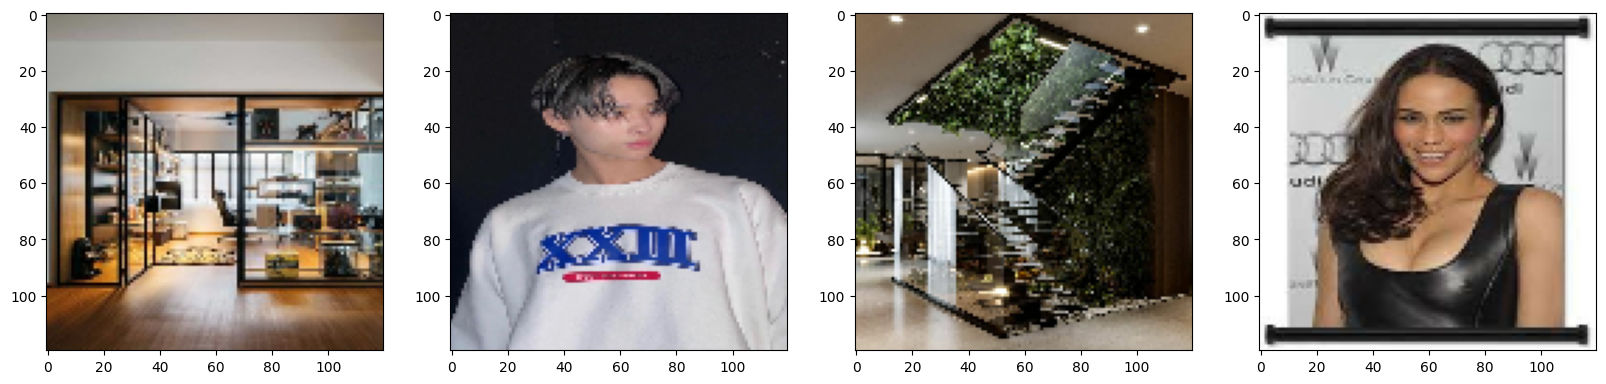

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# **4. Albumentation Setting für die Augmentatition den Bildern aufstellen**

In [17]:
augmentor = alb.Compose([alb.RandomCrop(width=500,height=500),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)], 
                        bbox_params= alb.BboxParams(format="albumentations",label_fields=["class_labels"]))

Laden eines Beispielbilds

In [18]:
image_path = "image24"

In [19]:
img = cv2.imread(os.path.join('data','train','images',image_path+".jpg"))

In [20]:
size= img.shape
print(size)

(1200, 914, 3)


In [21]:
with open(os.path.join('data','train','labels',image_path+'.json'),'r') as f:
  label = json.load(f)

In [22]:
label['shapes'][0]['points']

[[139.54430379746827, 54.43037974683544],
 [764.8607594936709, 751.8987341772151]]

Koordinaten Extrahieren und Maßstab ändern

In [23]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [24]:
coords

[139.54430379746827, 54.43037974683544, 764.8607594936709, 751.8987341772151]

In [25]:
coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

In [26]:
coords

[0.15267429299504187,
 0.04535864978902954,
 0.8368279644350886,
 0.6265822784810127]

Augmentation implimentieren

In [27]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [28]:
augmented['bboxes'][0]


(0.0, 0.7522025316455697, 0.7637215189873419, 1.0)

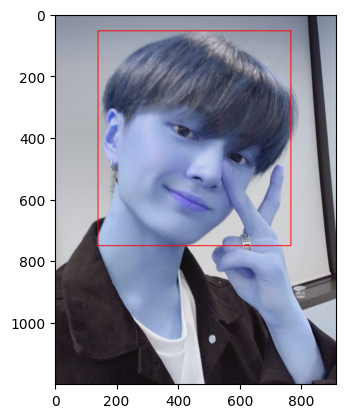

In [33]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [size[1],size[0]]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [size[1],size[0]]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

Aug-data Ordner herstellen

In [29]:
for path in ['train','test','val']:
  for folder in ['images','labels']:
   PATH = os.path.join('aug_data',path,folder)
   os.makedirs(PATH)

# **5. Augmentation Pipeline durchführen**

In [30]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        size = img.shape

        coords = [0,0,0,0]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Requested crop size (500, 500) is larger than the image size (231, 219)
Requested crop size (500, 500) is larger than the image size (259, 194)
Requested crop size (500, 500) is larger than the image size (613, 460)
x_max is less than or equal to x_min for bbox [0.8317323943661973, 0.5497395475629471, 0.5485, 0.0, 'face'].
y_max is less than or equal to y_min for bbox [0.44457068657685445, 0.2988298829882988, 0.6090461505166911, 0.16633663366336635, 'face'].
x_max is less than or equal to x_min for bbox [0.6501111218475215, 0.43881856540084385, 0.24749573227687047, 0.12130801687763712, 'face'].
x_max is less than or equal to x_min for bbox [0.7181190902121134, 0.4221409121851599, 0.3475594173268591, 0.0966643975493533, 'face'].
Requested crop size (500, 500) is larger than the image size (509, 339)
Requested crop size (500, 500) is larger than the image size (255, 198)
Requested crop size (500, 500) is larger than the image size (275, 183)
x_max is less than or equal to x_min for bbox 

## **6.Die Augmented Bildern zu eine Tensorflow Dataset laden**

In [31]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle= False)
train_images = train_images.map(load_image)

In [32]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle= False)
test_images = test_images.map(load_image)

In [33]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle= False)
val_images = val_images.map(load_image)

In [34]:
train_images.as_numpy_iterator().next()

array([[[0.25762525, 0.25762525, 0.26089326],
        [0.26691177, 0.26691177, 0.26233658],
        [0.25893247, 0.26122007, 0.24651416],
        ...,
        [0.6824893 , 0.50601864, 0.52589875],
        [0.64738584, 0.46699372, 0.50718963],
        [0.6013073 , 0.440523  , 0.50653595]],

       [[0.1126634 , 0.11094772, 0.12312092],
        [0.13161765, 0.13161765, 0.13553922],
        [0.12377451, 0.12377451, 0.12900326],
        ...,
        [0.67867666, 0.4945263 , 0.517974  ],
        [0.6522061 , 0.469363  , 0.5019608 ],
        [0.6096405 , 0.44656858, 0.49885607]],

       [[0.28477666, 0.28477666, 0.27758715],
        [0.3254085 , 0.32900324, 0.31037584],
        [0.31949887, 0.32309365, 0.3044662 ],
        ...,
        [0.67747843, 0.49376372, 0.51699364],
        [0.6502452 , 0.47132388, 0.5019608 ],
        [0.6117647 , 0.44248357, 0.4950979 ]],

       ...,

       [[0.15792505, 0.15825178, 0.1566182 ],
        [0.17189558, 0.1722223 , 0.16339901],
        [0.1578703 , 0

Labels vorbereiten

In [35]:
def load_labels(label_path):
  with open(label_path.numpy(),'r', encoding = "utf-8") as f:
    label = json.load(f)
  
  return [label['class']],label['bbox']

In [36]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle= False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [37]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle= False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [38]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle= False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [39]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.415 , 0.    , 1.    , 0.5723], dtype=float16))

# **7. Combine Image and Label Sampels**

7.1 Check Partition Lengths

In [40]:
len(train_images), len(train_labels), len(test_images), len(test_labels),len(val_images), len(val_labels)

(900, 900, 180, 180, 240, 240)

7.2 Create Final Dataset (Image/Label)

In [41]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [42]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [43]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [44]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.11426, 0.     , 0.7295 , 0.459  ],
        [0.3545 , 0.     , 0.9697 , 0.609  ],
        [0.2345 , 0.515  , 0.8496 , 1.     ],
        [0.05627, 0.533  , 0.6714 , 1.     ],
        [0.4658 , 0.7583 , 0.882  , 1.     ],
        [0.1986 , 0.724  , 0.5454 , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.07153, 0.     , 0.947  , 0.8594 ]], dtype=float16))

7.3 View Images and Annotations

In [45]:
data_samples = train.as_numpy_iterator()

In [46]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


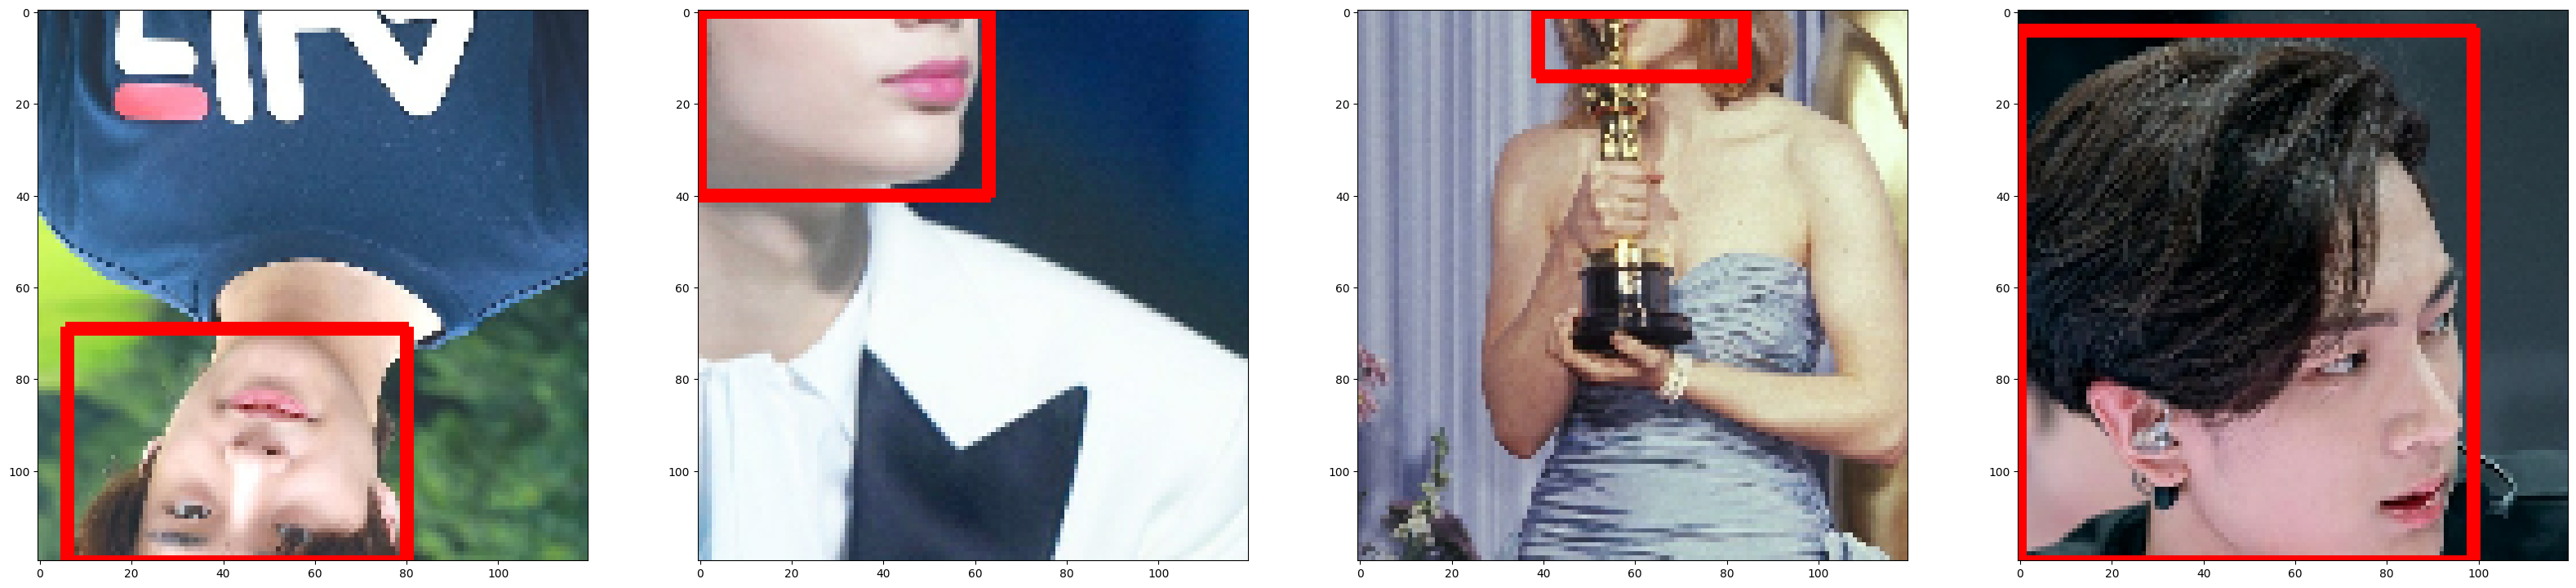

In [47]:
fig, ax = plt.subplots(ncols=4, figsize=(40, 40))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# **8. Aufbauen des Deep Learning-Modells**

### 8.1 Base Network sowie Layers importieren und VGG16 installieren

In [48]:
vgg = VGG16(include_top=False)

In [49]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.2 Eine Instanz des Neural Networks bauen

In [50]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.3 Testen des Neural Networks

In [51]:
facetracker = build_model()

In [52]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [53]:
X, y = train.as_numpy_iterator().next()

In [54]:
X.shape

(8, 120, 120, 3)

In [55]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 8s 8s/step


In [56]:
classes, coords

(array([[0.59868294],
        [0.511072  ],
        [0.6101597 ],
        [0.58597726],
        [0.59589136],
        [0.55486715],
        [0.5831619 ],
        [0.527012  ]], dtype=float32),
 array([[0.59540296, 0.33753866, 0.5057614 , 0.446493  ],
        [0.5756908 , 0.3976512 , 0.4643894 , 0.4170734 ],
        [0.54521424, 0.24562107, 0.44645652, 0.43398532],
        [0.5648603 , 0.4026601 , 0.49705544, 0.4867142 ],
        [0.6219451 , 0.3616124 , 0.5950517 , 0.39070266],
        [0.5878666 , 0.44283265, 0.4852681 , 0.39964303],
        [0.54521847, 0.3410258 , 0.44519314, 0.43217716],
        [0.55987114, 0.35254657, 0.48379752, 0.51256526]], dtype=float32))

# **9.Define Losses and Optimizer**

## 9.1 Define Optimizer

In [57]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/ batches_per_epoch

In [58]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [59]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [60]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [61]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.1008368>

In [62]:
classloss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.59549654>

In [63]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.1008368>

# **10.Train Neural Network**

## 10.1 Create Custom Model Class

In [64]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [65]:
model = FaceTracker(facetracker)

In [66]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [67]:
logdir='logs'

In [68]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [69]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
113/113 [==============================] - 31s 195ms/step - total_loss: 1.7404 - class_loss: 0.3237 - regress_loss: 1.5786 - val_total_loss: 2.6745 - val_class_loss: 1.0242 - val_regress_loss: 2.1624
Epoch 2/10
113/113 [==============================] - 20s 163ms/step - total_loss: 0.7617 - class_loss: 0.1497 - regress_loss: 0.6868 - val_total_loss: 1.1348 - val_class_loss: 0.2847 - val_regress_loss: 0.9925
Epoch 3/10
113/113 [==============================] - 20s 164ms/step - total_loss: 0.3871 - class_loss: 0.0644 - regress_loss: 0.3549 - val_total_loss: 0.8803 - val_class_loss: 0.1524 - val_regress_loss: 0.8041
Epoch 4/10
113/113 [==============================] - 20s 164ms/step - total_loss: 0.3399 - class_loss: 0.0716 - regress_loss: 0.3041 - val_total_loss: 0.4346 - val_class_loss: 0.0657 - val_regress_loss: 0.4018
Epoch 5/10
113/113 [==============================] - 20s 164ms/step - total_loss: 0.1649 - class_loss: 0.0264 - regress_loss: 0.1517 - val_total_loss: 1.13

## 10.3 Plot Performance

In [70]:
hist.history

{'total_loss': [0.17430612444877625,
  0.2454131841659546,
  0.20575307309627533,
  0.33140259981155396,
  0.014400242827832699,
  0.02604176104068756,
  0.03787551820278168,
  0.002184015465900302,
  0.00485552754253149,
  0.013065993785858154],
 'class_loss': [0.002930711954832077,
  0.21587423980236053,
  0.016707751899957657,
  0.005434500519186258,
  5.662444664267241e-07,
  3.576281244477286e-07,
  5.364456228562631e-06,
  0.0003284414706286043,
  4.102449747733772e-05,
  9.939225492416881e-06],
 'regress_loss': [0.17284077405929565,
  0.13747605681419373,
  0.19739919900894165,
  0.32868534326553345,
  0.014399959705770016,
  0.026041582226753235,
  0.037872835993766785,
  0.0020197946578264236,
  0.004835015162825584,
  0.013061024248600006],
 'val_total_loss': [2.6744508743286133,
  1.1348263025283813,
  0.8802685737609863,
  0.43460676074028015,
  1.1323281526565552,
  1.4540430307388306,
  1.4732071161270142,
  0.6303435564041138,
  1.8467528820037842,
  2.4766907691955566],

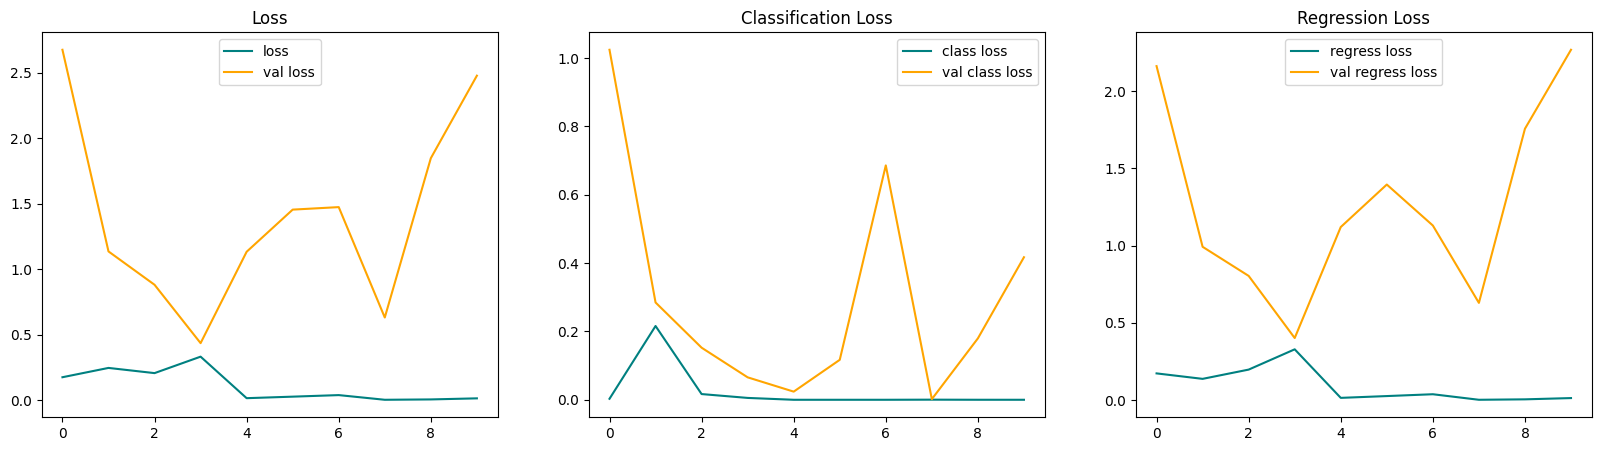

In [71]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# **11. Make Prediction**

## 11.1 Making Prediction on test set for valuation purpose

In [72]:
test_data = test.as_numpy_iterator()

In [73]:
test_sample = test_data.next()

In [74]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


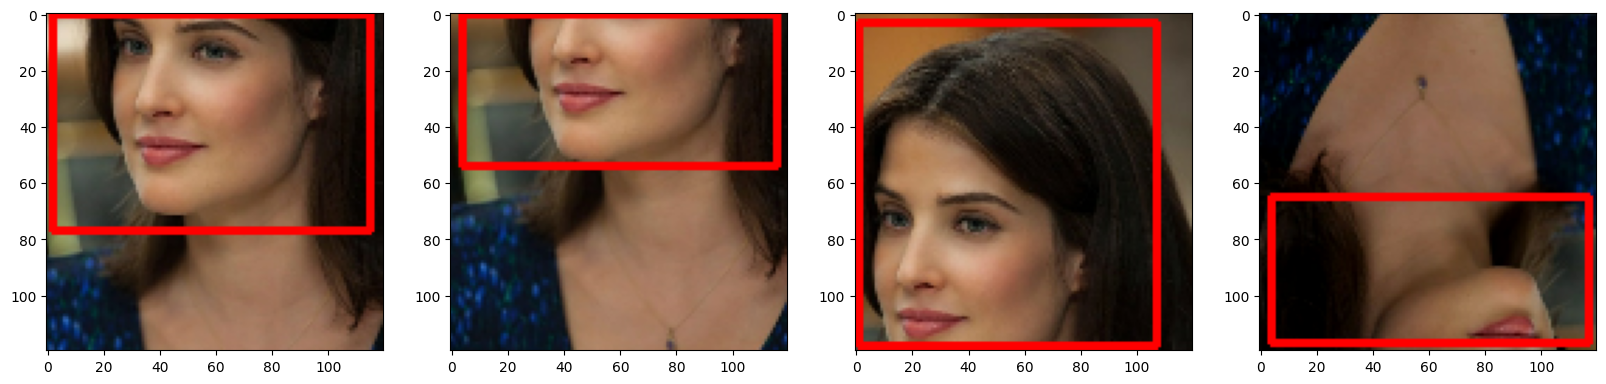

In [75]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the model

In [76]:
facetracker.save('facetracker.h5')

In [77]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()